# Import Libraries

In [1]:
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.datasets import boston_housing
from keras import layers
from keras.initializers import Initializer
from sklearn.cluster import KMeans

# Definition of the RBF Layer
The code is based on the implementation of Petra Vidnerova et. all, which can be found [here](https://github.com/PetraVidnerova/rbf_keras). Also, the [Keras Tutorial on creating a custom layer](https://www.tutorialspoint.com/keras/keras_customized_layer.htm) is followed.

In [2]:
class RBFLayer(layers.Layer):
    # output_dim: number of hidden units (number of outputs of the layer)
    # initializer: instance of initializer to initialize centers
    # betas: float, initial value for betas (beta = 1 / 2*pow(sigma,2))
    def __init__(self, output_dim, initializer, betas=1.0, **kwargs):
        self.betas = betas
        self.output_dim = output_dim
        self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers', shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer, trainable=False)
        sigma = np.zeros(self.output_dim)
        for i in range(0, self.output_dim):
            d_max = 0
            for j in range(0, self.output_dim):
                d = np.linalg.norm(self.centers[i] - self.centers[j])
                if d > d_max:
                    d_max = d
            sigma[i] = d_max / np.sqrt(2 * self.output_dim)
        self.betas = np.ones(self.output_dim) / (2 * (sigma ** 2))
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs, *args, **kwargs):
        C = tf.expand_dims(self.centers, -1)  
        H = tf.transpose(C - tf.transpose(inputs))  
        return tf.exp(-self.betas * tf.math.reduce_sum(H ** 2, axis=1))

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.output_dim




## KMeans Definition for the Centers
Petra Vinderova also implements the [KMeans Initialiser](https://github.com/PetraVidnerova/rbf_keras/blob/master/kmeans_initializer.py)

In [3]:
class InitCentersKMeans(Initializer):
    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter
        super().__init__()

    def __call__(self, shape, dtype=None, *args):
        assert shape[1] == self.X.shape[1]
        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_

## Definition of the necessary metrics
The following metrics are based on these implementations:
- [R2 score](https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/)
- [Root Mean Squared Error](https://stackoverflow.com/questions/43855162/rmse-rmsle-loss-function-in-keras) / and this [issue](https://github.com/keras-team/keras/issues/10706)
- [Mean Squared Error](https://stackoverflow.com/questions/67216102/keras-mean-squared-error-mse-calculation-definition-for-images)

In [4]:
def r2_score(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())


def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))


def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

## Data Preprocessing

In [5]:
test_length = 0.25
(x_train, y_train), (x_test, y_test) = boston_housing.load_data(test_split=test_length)

normalise = True
if normalise:
    x_train = (x_train - np.mean(x_train, axis = 0))/np.std(x_train, axis = 0)
    x_test = (x_test - np.mean(x_test, axis = 0))/np.std(x_train, axis = 0)

65536/57026 [==================================] - 0s 0us/step


## General Parameters

In [6]:
length_validation = 0.2
learning_rate = 0.001
epochs = 100
batch_size = 256
neurons_rbf_total = [round(0.1*len(x_train)), round(0.5*len(x_train)), round(0.9*len(x_train))]
neurons_output = 128
neurons_final = 1

## Baseline Mode;

2022-09-20 09:10:50.974825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 09:10:51.091826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 09:10:51.092628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 09:10:51.094407: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

4/4 [==============================] - 0s 3ms/step - loss: 82.8838 - r2_score: -0.1163 - root_mean_squared_error: 8.9188


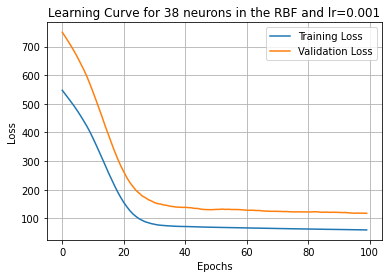

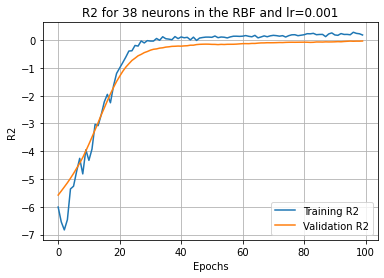

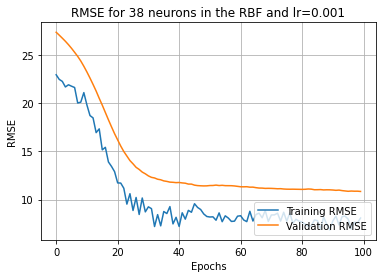

4/4 [==============================] - 0s 3ms/step - loss: 76.7373 - r2_score: -0.0514 - root_mean_squared_error: 8.6236


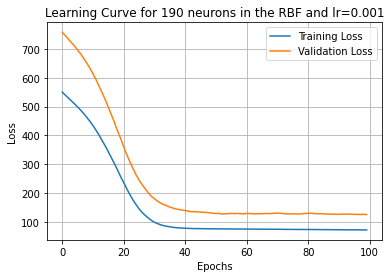

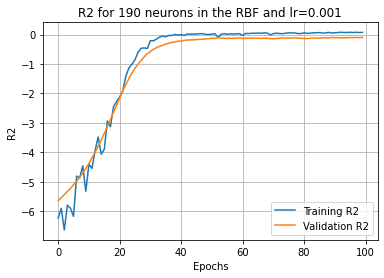

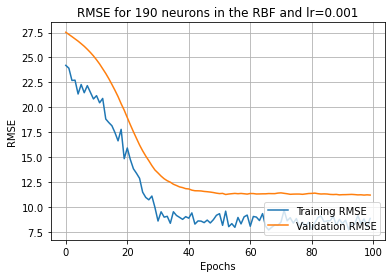

4/4 [==============================] - 0s 2ms/step - loss: 76.6773 - r2_score: -0.0511 - root_mean_squared_error: 8.6213


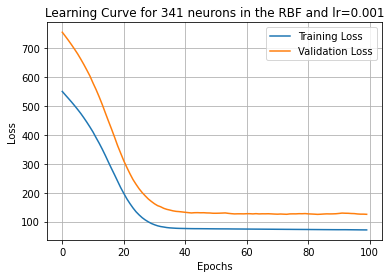

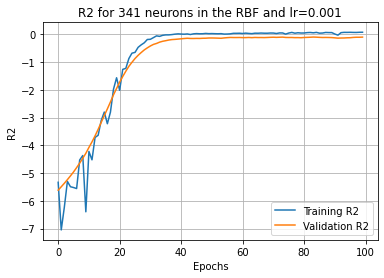

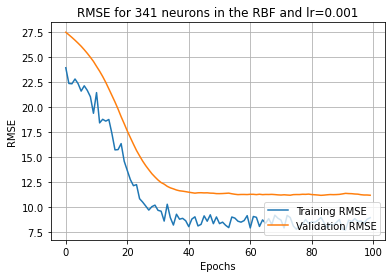

In [7]:
for neurons_rbf in neurons_rbf_total:
    model = Sequential()
    model.add(RBFLayer(neurons_rbf, initializer=InitCentersKMeans(x_train), input_shape=(13, )))
    model.add(Dense(neurons_output))
    model.add(Dense(neurons_final))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), loss=mean_squared_error, metrics=[r2_score, root_mean_squared_error])

    fit_model = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=length_validation, verbose=0)
    score = model.evaluate(x_test, y_test)


    train_loss = [fit_model.history['loss'][i] for i in range(100)]
    validation_loss = [fit_model.history['val_loss'][i] for i in range(100)]

    train_r2 = fit_model.history['r2_score']
    validation_r2 = fit_model.history['val_r2_score']

    train_rmse = fit_model.history['root_mean_squared_error']
    validation_rmse = fit_model.history['val_root_mean_squared_error']

    plt.plot(train_loss)
    plt.plot(validation_loss)

    plt.title('Learning Curve for ' + str(neurons_rbf) + ' neurons in the RBF and lr=0.001')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
    plt.grid()
    plt.show()

    plt.plot(train_r2)
    plt.plot(validation_r2)

    plt.title('R2 for ' + str(neurons_rbf) + ' neurons in the RBF and lr=0.001')
    plt.xlabel('Epochs')
    plt.ylabel('R2')
    plt.legend(['Training R2', 'Validation R2'], loc='lower right')
    plt.grid()
    plt.show()

    plt.plot(train_rmse)
    plt.plot(validation_rmse)

    plt.title('RMSE for ' + str(neurons_rbf) + ' neurons in the RBF and lr=0.001')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend(['Training RMSE', 'Validation RMSE'], loc='lower right')
    plt.grid()
    plt.show()